In [1]:
import os
import glob
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [2]:
import matplotlib
import matplotlib.pyplot as plt

font_path = './HelveticaNeue.ttc'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['YourFontName'] + plt.rcParams['font.serif']
plt.rcParams["font.weight"] = "normal"
matplotlib.font_manager.fontManager.addfont(font_path)

In [3]:
def filter_outliers(y, x, num, threshold):
    outliers = [i for i in range(num, len(y) - num) if np.abs(y[i] - np.mean(y[i-num:i+num])) > threshold]
    return np.delete(x, outliers), np.delete(y, outliers)

def smooth(x, y, window_size):
    window = np.ones(window_size)/window_size
    return x[window_size-1:], np.convolve(y, window, mode='valid')

def mean_window(x, y, window_size):
    return np.mean(x.reshape(-1, window_size), axis=1), np.mean(y.reshape(-1, window_size), axis=1)

def plot(x, y, label, ylim=None):
    plt.plot(x, y, label=label)
    if ylim:
        plt.ylim(ylim)
    plt.xlabel('Tokens')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

def get_tokens_df(target_value,loss_df):
    diff = np.abs(loss_df['Value'] - target_value)
    index = diff.idxmin()
    return loss_df['Step'][index]

def get_tokens(target_value,x,y):
    diff = np.abs(y - target_value)
    index = np.argmin(diff)
    return x[index] 

In [23]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def plotLRLoss(min_values, LR):
    plt.figure(figsize=(5,5))
    y_loss = np.array([k for k in min_values.keys()])
    x_learning_rate = np.log(np.array([value[0] for k,value in min_values.items()]))
    
    plt.scatter(x_learning_rate, y_loss, s = 5, color='red', label='Experimental Results')
    coeffs = np.polyfit(x_learning_rate, y_loss, deg=1)
    print('k,b:', coeffs)

    f = np.poly1d(coeffs)
    plt.plot(x_learning_rate,f(x_learning_rate), '-b', label='Fitted line')
    plt.legend()
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.rc('xtick', labelsize=7)
    plt.rc('ytick', labelsize=7)
    plt.show()
    
def plotLRTokens(path_save, filename_prefix,model_size, color_upper_bound, color_lower_bound, SMOOTH, threshold, batch_size_list, lr_list, bs_min_values):
    for bs in batch_size_list:
        loss_L = []
        for i in range(color_upper_bound,color_lower_bound, -1):
            loss_L.append(i/100)

        df = pd.DataFrame({'loss': loss_L})

        df_L = []
        for LR in lr_list:
            csv_name = path_save + 'llama_' + model_size + filename_prefix%(LR,bs,LR)
            loss_df = pd.read_csv(csv_name + '.csv')

            x, y = loss_df['Step'].values, loss_df['Value'].values
            x, y = filter_outliers(y, x, SMOOTH, threshold)
            x, y = smooth(x, y, SMOOTH) 
            df_L.append(loss_df)

            lr_L = []
            for loss in loss_L:
                t = get_tokens(loss,x,y)
                lr_L.append(t)
            df[LR] = lr_L

        for col in df.columns:
            if col == 256 or col == 128:
                df.loc[df[col].diff() <= 0, col] = np.nan

        flag = 0
        min_values = {}
        
        cmap = plt.get_cmap('plasma_r')
        norm = plt.Normalize(COLOR_LOWER_BOUND/100, COLOR_UPPER_BOUND/100)

        fig, ax = plt.subplots()
        control_num = int(df.shape[0]/2)
        
        for index, row in df.iterrows(): 
            min_value = min(row.values[1:])
            min_column = float((df.columns[row.values[1:].tolist().index(min_value)+1]).split('_')[0])

            tmp = row.values[0] 
            x = [float((_).split('_')[0]) for _ in df.columns[1:].values]
            y = row.values[1:].astype(float)
            plt.semilogy(x, y, linestyle='dashed', color=cmap(norm(tmp)), label=f'index={tmp}')
            plt.scatter(x, y, color=cmap(norm(tmp)))  # 添加散点

            mask = ~np.isnan(y)
            
            mask = mask
            x = [x[idx] for idx in range(0, len(mask)) if mask[idx]]
            y = y[mask]

            z = np.polyfit(np.log(x), y, deg=2)
            p = np.poly1d(z)
            pseudo_x = np.arange(min(x) * 0.7 * 10 ** 5,max(x) * 1.3 * 10 ** 5,1) * 0.00001
            pseudo_y = p(np.log(pseudo_x))

            plt.semilogy(pseudo_x, pseudo_y, color=cmap(norm(tmp)), label=f'Fitted Curve for index={tmp}')  # 绘制拟合后的曲线
            min_x = pseudo_x[np.argmin(pseudo_y)]
            min_y = min(pseudo_y) 
            plt.scatter(min_x, min_y, color=cmap(norm(tmp))) 
            min_values[tmp] = (min_x, min_y)
        plt.title('Model Size ' + str(model_size) +', Batch Size '+ str(bs))
        
        
        x = np.array([value[0] for value in min_values.values()])
        y = np.array([value[1] for value in min_values.values()])
        coeffs = np.polyfit(np.log(x), y, deg=1)
        f = np.poly1d(coeffs)
        
        plt.plot(x,y, '-r', label='Min Values')
        plt.xscale('log')
        ax = plt.gca() 
        ax.tick_params(axis='both', labelsize=12)
        plt.xlabel('Learning Rate')
        plt.ylabel('Token Processed')
        cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
        cbar.set_label('Training Loss')
        # plt.savefig('heatmap' + '_' + str(model_size) + '_' + str(bs) + '.pdf')  # 显示图

        plotLRLoss(min_values, LR)
        bs_min_values[bs].update(min_values)
    return bs_min_values

k,b: [0.28975984 4.79549885]


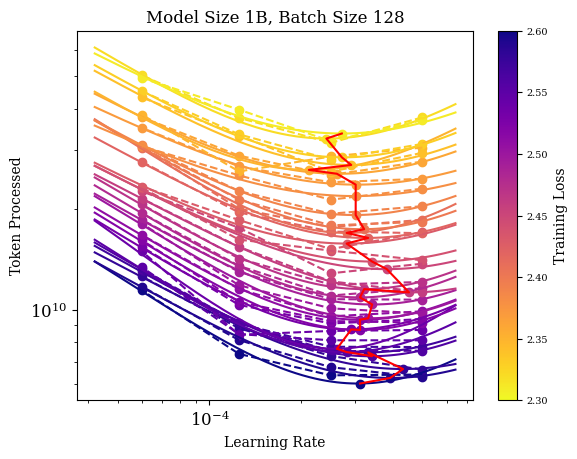

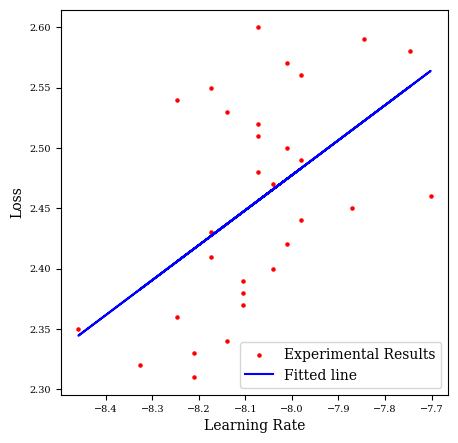

In [24]:
COLOR_UPPER_BOUND = 260
COLOR_LOWER_BOUND = 230
SMOOTH = 20
threshold = 0.01
batch_size_pred = [128]

LR_L_pred = ['5e-4_5e-5', '2.5e-4_2.5e-5', '1.25e-4_1.25e-5', '6e-5_6e-6', ]
model_size = '1B'
bs_min_values_pred = {}
for bs in batch_size_pred:
    bs_min_values_pred[bs] = {}
bs_min_values_pred = plotLRTokens(path_save, filename_prefix, model_size, COLOR_UPPER_BOUND, COLOR_LOWER_BOUND, SMOOTH, threshold, batch_size_pred, LR_L_pred, bs_min_values_pred)

k,b: [0.34182933 5.36114555]
{512: {3.1: (0.0009600000000000001, 6791967119.849335), 3.09: (0.00102, 6888994294.418213), 3.08: (0.00102, 6996500599.716156), 3.07: (0.0010400000000000001, 7059230098.68161), 3.06: (0.00107, 7571203988.791016), 3.05: (0.0010500000000000002, 8038634342.429871), 3.04: (0.00103, 8498639435.873932), 3.03: (0.00101, 8791444324.843994), 3.02: (0.00101, 9089784290.128357), 3.01: (0.0009800000000000002, 9112067988.377563), 3.0: (0.00102, 9438123344.413269), 2.99: (0.00101, 9799067502.42517), 2.98: (0.0010400000000000001, 10255623931.232239), 2.97: (0.00101, 10570221199.50354), 2.96: (0.00101, 11367635777.998535), 2.95: (0.00101, 12165842035.496765), 2.94: (0.00103, 12321047883.123901), 2.93: (0.001, 13788249068.72467), 2.92: (0.0009500000000000001, 14451611328.300903), 2.91: (0.0010400000000000001, 16053826635.464539)}}


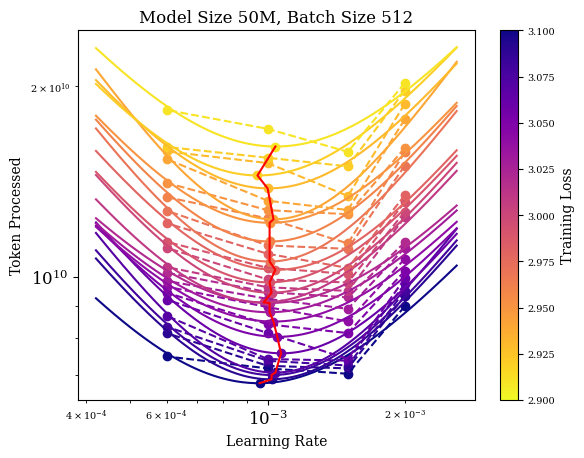

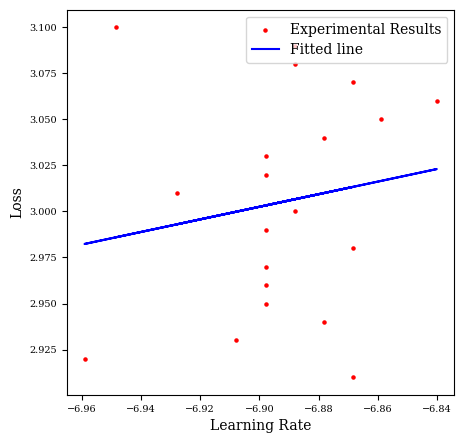

In [6]:
COLOR_UPPER_BOUND = 310
COLOR_LOWER_BOUND = 290
SMOOTH = 20
threshold = 0.01
batch_size_small = [512]
LR_L_small = ['2e-3_2e-4','1.5e-3_1.5e-4','1e-3_1e-4','6e-4_6e-5']
model_size = '50M'
bs_min_values_small = {}
for bs in batch_size_small:
    bs_min_values_small[bs] = {}
bs_min_values_small = plotLRTokens(path_save, filename_prefix,model_size, COLOR_UPPER_BOUND, COLOR_LOWER_BOUND, SMOOTH, threshold,batch_size_small, LR_L_small, bs_min_values_small)

k,b: [0.75816564 8.40209459]
{256: {2.8: (0.0005975, 4516841980.168495), 2.79: (0.0005775, 4698347756.425262), 2.78: (0.0005675000000000001, 4809889459.239555), 2.77: (0.0005975, 4982078657.127762), 2.76: (0.0005875, 5111356049.526573), 2.75: (0.0005675000000000001, 5197941897.101181), 2.74: (0.0005675000000000001, 5288109980.50354), 2.73: (0.0005575, 5483865972.009888), 2.72: (0.0005675000000000001, 5808441292.55928), 2.71: (0.0005675000000000001, 6316594963.873947), 2.7: (0.0005475, 6576597126.956818), 2.69: (0.0005475, 6786518500.504776), 2.68: (0.0005275000000000001, 6767757709.579178), 2.67: (0.0005175000000000001, 6789032645.332993), 2.66: (0.0005075, 7261274484.84523), 2.65: (0.0005475, 7695379062.520035), 2.64: (0.0004975, 7775642234.121796), 2.63: (0.0005075, 8453544921.123688), 2.62: (0.00046750000000000003, 8506860942.318695), 2.61: (0.0004975, 8852656818.833893), 2.6: (0.0004975, 8994141386.77658), 2.59: (0.00047750000000000006, 9024792275.72644), 2.58: (0.00044750000000000

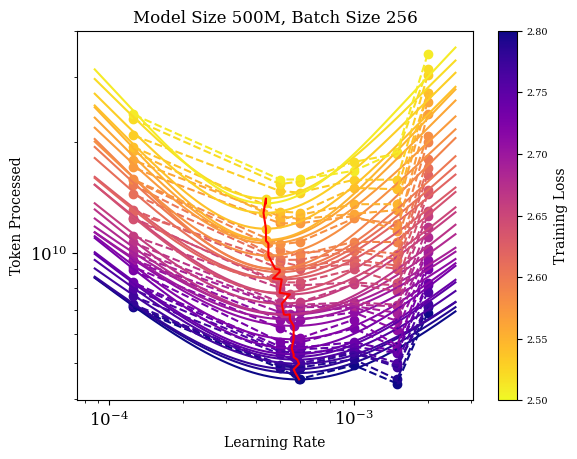

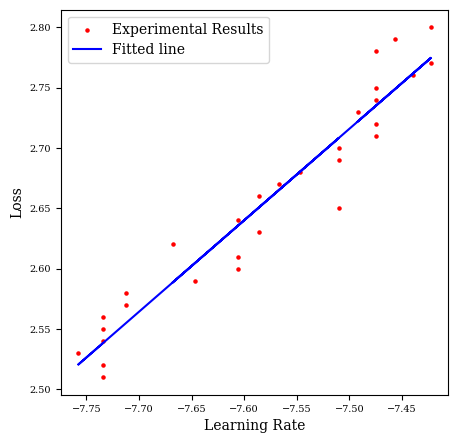

In [7]:
COLOR_UPPER_BOUND = 280
COLOR_LOWER_BOUND = 250
SMOOTH = 20
threshold = 0.01
batch_size_large = [256]
LR_L_large = ['2e-3_2e-4','1.5e-3_1.5e-4','1e-3_1e-4','6e-4_6e-5','5e-4_5e-5','1.25e-4_1.25e-5']
model_size = '500M'
bs_min_values_large = {}
for bs in batch_size_large:
    bs_min_values_large[bs] = {}
bs_min_values_large = plotLRTokens(path_save, filename_prefix, model_size, COLOR_UPPER_BOUND, COLOR_LOWER_BOUND, SMOOTH, threshold, batch_size_large, LR_L_large, bs_min_values_large)  

k,b: [0.07516717 3.34353187]
{256: {2.9: (0.0008875, 5565778968.658798), 2.89: (0.0007675000000000001, 6008498886.946808), 2.88: (0.0008175000000000001, 6471416984.238266), 2.87: (0.0007175, 6824701762.103821), 2.86: (0.0007375000000000001, 6861753203.130905), 2.85: (0.0008775, 7192580320.102524), 2.84: (0.0008275000000000001, 7612621181.163544), 2.83: (0.0007275000000000001, 7915512665.410217), 2.82: (0.0007575, 8546881548.813416), 2.81: (0.0006675, 8978475431.412354), 2.8: (0.0007175, 9186892801.320404), 2.79: (0.0007475, 9358875439.300598), 2.78: (0.0008675000000000001, 9685605081.899048), 2.77: (0.0012775000000000002, 10779442076.587494), 2.76: (0.0006675, 11106493611.641632), 2.75: (0.0007575, 12388397513.008362), 2.74: (0.0006675, 12742256829.371521), 2.73: (0.0008275000000000001, 14677171707.336395), 2.72: (0.0007075, 15232749044.943024), 2.71: (0.0006375, 16078900949.342407)}}


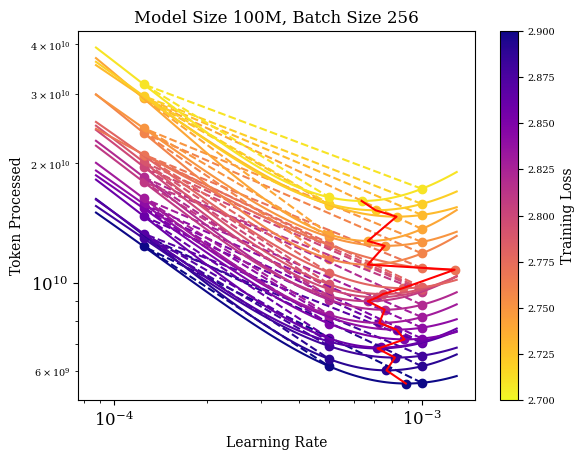

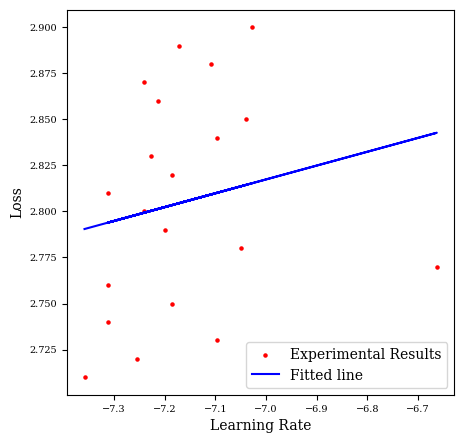

In [8]:
COLOR_UPPER_BOUND = 290
COLOR_LOWER_BOUND = 270
SMOOTH = 20
threshold = 0.01
batch_size_mid = [256]
LR_L_mid = ['1e-3_1e-4','1.25e-4_1.25e-5','5e-4_5e-5']
model_size = '100M'
bs_min_values_mid = {}
for bs in batch_size_mid:
    bs_min_values_mid[bs] = {}
bs_min_values_mid = plotLRTokens(path_save, filename_prefix,model_size, COLOR_UPPER_BOUND, COLOR_LOWER_BOUND, SMOOTH, threshold,batch_size_mid, LR_L_mid, bs_min_values_mid)

In [9]:
def filter_anomaly(x, y, y_pred, threshold):
    cleaned_x, cleaned_y = [], []
    for i in range(len(x)):
        if abs(y[i] - y_pred[i]) < threshold:
            cleaned_x.append(x[i])
            cleaned_y.append(y[i])
    return cleaned_x, cleaned_y

k,b: [0.115203   1.89415934]
k,b: [0.02695348 1.22429916]
k,b: [0.28614138 3.14493951]
k,b: [0.17023535 2.26395193]


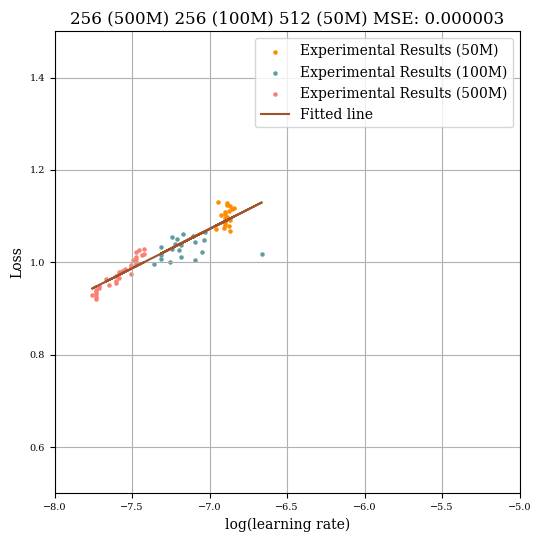

2.549544775402597e-06


In [10]:
anomaly_threshold = 100
mse_score_list1 = []
for bs_large in batch_size_large:
    for bs_mid in batch_size_mid:
        for bs_small in batch_size_small:
            dataset_x = []
            dataset_y = []
            # plot 50m model
            plt.figure(figsize=(6,6))
            bs_min_value = bs_min_values_small[bs_small]
            y_loss = np.array([k for k in bs_min_value.keys() ])
            x_learning_rate = np.array([value[0] for k,value in bs_min_value.items()])
            
            coeffs = np.polyfit(np.log(x_learning_rate), np.log(y_loss), deg=1)
            print('k,b:', coeffs)
            f = np.poly1d(coeffs)
            cleaned_x, cleaned_y = filter_anomaly(np.log(x_learning_rate), np.log(y_loss), f(np.log(x_learning_rate)), anomaly_threshold)
            dataset_x.extend(cleaned_x)
            dataset_y.extend(cleaned_y)
            # plt.plot(np.log(x_batch_size),f(np.log(x_batch_size)), 'darkorange', label='Fitted line (50M)')
            # plt.scatter(np.log(x_batch_size), y_loss, color='darkorange')
            plt.scatter(cleaned_x, cleaned_y, s = 5, color='darkorange',  label='Experimental Results (50M)')

            # plot 100m model
            bs_min_value = bs_min_values_mid[bs_mid]
            y_loss = np.array([k for k in bs_min_value.keys() ])
            x_learning_rate = np.array([value[0] for k,value in bs_min_value.items()])
            coeffs = np.polyfit(np.log(x_learning_rate), np.log(y_loss), deg=1)
            print('k,b:', coeffs)
            f = np.poly1d(coeffs)
            cleaned_x, cleaned_y = filter_anomaly(np.log(x_learning_rate), np.log(y_loss), f(np.log(x_learning_rate)), anomaly_threshold)
            dataset_x.extend(cleaned_x)
            dataset_y.extend(cleaned_y)
            plt.scatter(cleaned_x, cleaned_y, s = 5, color='cadetblue', label='Experimental Results (100M)')

            # plot 500 m model
            bs_min_value = bs_min_values_large[bs_large]
            y_loss = np.array([k for k in bs_min_value.keys() ])
            x_learning_rate = np.array([value[0] for k,value in bs_min_value.items()])
            
            coeffs = np.polyfit(np.log(x_learning_rate), np.log(y_loss), deg=1)
            print('k,b:', coeffs)
            f = np.poly1d(coeffs)
            cleaned_x, cleaned_y = filter_anomaly(np.log(x_learning_rate), np.log(y_loss), f(np.log(x_learning_rate)), anomaly_threshold)
            dataset_x.extend(cleaned_x)
            dataset_y.extend(cleaned_y)
            plt.scatter(cleaned_x, cleaned_y, s = 5, color='salmon',  label='Experimental Results (500M)')

            
            coeffs = np.polyfit(dataset_x, dataset_y, deg=1)
            print('k,b:', coeffs)
            f = np.poly1d(coeffs)
            plt.plot(dataset_x,f(dataset_x), 'sienna', label='Fitted line')
            mse_score = (np.square(dataset_y - f(dataset_x))**2).mean()
            mse_score_list1.append(mse_score)

            plt.legend()
            plt.grid()
            plt.xlabel('log(learning rate)')
            plt.ylabel('Loss')
            plt.ylim(0.5, 1.5)
            plt.xlim(-8, -5)
            plt.title(str(bs_large) + ' (500M) ' + str(bs_mid) + ' (100M) ' + str(bs_small) + ' (50M) MSE: {:.6f}'.format(mse_score) )
            plt.rc('xtick', labelsize=7)
            plt.rc('ytick', labelsize=7)
            plt.show()
print(np.mean(mse_score_list1))

In [11]:
ms_lr_bs_loss_tk_file = 'modelsize_lr_batchsize_loss_tokens_v2.csv'
model_size_list = []
batch_size_list = []
loss_list = []
lr_list = []
tokens_list = []

import pandas as pd
df = pd.DataFrame()

for bs_min_value, _ in bs_min_values_small.items():
    for k, v in _.items():
        model_size_list.append('50M')
        batch_size_list.append(bs_min_value)
        loss_list.append(k)
        lr_list.append(v[0])
        tokens_list.append(v[1])
        
for bs_mid_value, _ in bs_min_values_mid.items():
    for k, v in _.items():
        model_size_list.append('100M')
        batch_size_list.append(bs_mid_value)
        loss_list.append(k)
        lr_list.append(v[0])
        tokens_list.append(v[1])
        
for bs_large_value, _ in bs_min_values_large.items():
    for k, v in _.items():
        model_size_list.append('500M')
        batch_size_list.append(bs_large_value)
        loss_list.append(k)
        lr_list.append(v[0])
        tokens_list.append(v[1])

for bs_pred_value, _ in bs_min_values_pred.items():
    for k, v in _.items():
        model_size_list.append('1B')
        batch_size_list.append(bs_pred_value)
        loss_list.append(k)
        lr_list.append(v[0])
        tokens_list.append(v[1])
    
    
df = pd.DataFrame({'model_size': model_size_list, 'batch_size': batch_size_list, 'loss':loss_list, 'lr':lr_list, 'tokens': tokens_list})
df.to_csv(ms_lr_bs_loss_tk_file, index=False)

In [12]:
df = pd.read_csv(ms_lr_bs_loss_tk_file)

In [13]:
threshold = 0.01 * 0.01
batch_size = [2816,2048,1024,512,256,128]
def samplePoints(lr_loss_bs_tokens_dict):
    sampled_bs_lr_loss = {}
    for _bs in lr_loss_bs_tokens_dict.keys():
        for _loss in lr_loss_bs_tokens_dict[_bs].keys():
            _lr, _tn = lr_loss_bs_tokens_dict[_bs][_loss]
            sampled_bs_lr_loss.update({_loss: (_bs, _lr, _tn)})
    return sampled_bs_lr_loss

In [14]:
sampled_bs_lr_loss_1B = samplePoints(bs_min_values_pred)
sampled_bs_lr_loss_500M = samplePoints(bs_min_values_large)
sampled_bs_lr_loss_100M = samplePoints(bs_min_values_mid)
sampled_bs_lr_loss_50M = samplePoints(bs_min_values_small)

In [15]:
sampled_points_flop_lr = []
sampled_points_N_lr = []
sampled_points_D_lr = []
sampled_points_ratio_lr = []

sampled_points_loss_D_1B = []
sampled_points_loss_D_100M = []
sampled_points_loss_D_500M = []
sampled_points_loss_D_50M = []

for k,v in sampled_bs_lr_loss_1B.items():
    sampled_points_flop_lr.append([v[2] * 131.24 * (10 ** 12), v[1]])
    sampled_points_N_lr.append([1 * (10 ** 9), v[1]])
    sampled_points_D_lr.append([v[2], v[1]])
    sampled_points_ratio_lr.append([v[2]/(1 * (10 ** 9)), v[1]])
    sampled_points_loss_D_1B.append([k, v[2]])
    
for k,v in sampled_bs_lr_loss_100M.items():
    sampled_points_flop_lr.append([v[2] * 30.17 * (10 ** 12), v[1]])
    sampled_points_N_lr.append([100 * (10 ** 6), v[1]])
    sampled_points_D_lr.append([v[2], v[1]])
    sampled_points_ratio_lr.append([v[2]/(100 * (10 ** 6)), v[1]])
    sampled_points_loss_D_100M.append([k, v[2]])
    
for k,v in sampled_bs_lr_loss_500M.items():
    sampled_points_flop_lr.append([v[2] * 80.71 * (10 ** 12), v[1]])
    sampled_points_N_lr.append([500 * (10 ** 6), v[1]])
    sampled_points_D_lr.append([v[2], v[1]])
    sampled_points_ratio_lr.append([v[2]/(500 * (10 ** 6)), v[1]])
    sampled_points_loss_D_500M.append([k, v[2]])
    
for k,v in sampled_bs_lr_loss_50M.items():
    sampled_points_flop_lr.append([v[2] * 16.91 * (10 ** 12), v[1]])
    sampled_points_N_lr.append([50 * (10 ** 6), v[1]])
    sampled_points_D_lr.append([v[2], v[1]])
    sampled_points_ratio_lr.append([v[2]/(50 * (10 ** 6)), v[1]])
    sampled_points_loss_D_50M.append([k, v[2]])

In [16]:
sampled_points_lr_loss = []
sampled_points_lr_loss_1B = []
sampled_points_lr_loss_100M = []
sampled_points_lr_loss_500M = []
sampled_points_lr_loss_50M = []
for k,v in sampled_bs_lr_loss_1B.items():
    sampled_points_lr_loss.append([v[1], k,v[2]/(1 * 10 ** 9)])
    sampled_points_lr_loss_1B.append([v[1], k])
for k,v in sampled_bs_lr_loss_100M.items():
    sampled_points_lr_loss.append([v[1], k, v[2]/(100 * 10 ** 6)])
    sampled_points_lr_loss_100M.append([v[1], k])
for k,v in sampled_bs_lr_loss_500M.items():
    sampled_points_lr_loss.append([v[1], k, v[2]/(500 * 10 ** 6)])
    sampled_points_lr_loss_500M.append([v[1], k])
for k,v in sampled_bs_lr_loss_50M.items():
    sampled_points_lr_loss.append([v[1], k, v[2]/(50 * 10 ** 6)])
    sampled_points_lr_loss_50M.append([v[1], k])

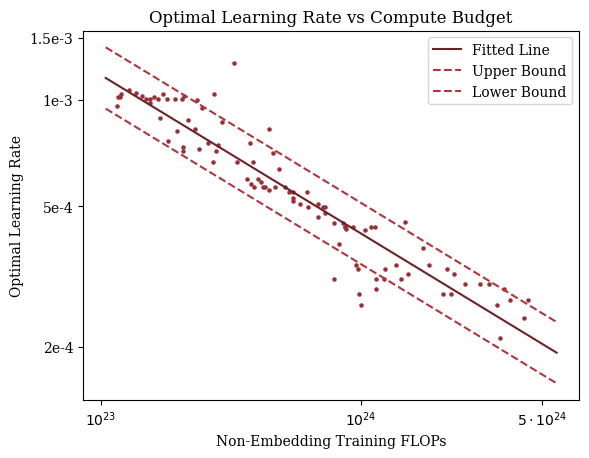

In [17]:
x = np.log(np.array(sampled_points_flop_lr)[:,0])
y = np.log(np.array(sampled_points_flop_lr)[:,1])

pseudo_x = np.arange(53, 58, 1)
coeffs = np.polyfit(x, y, deg=1)
f = np.poly1d(coeffs)
plt.plot(pseudo_x, f(pseudo_x), color = '#6d2227', label='Fitted Line')
plt.plot(pseudo_x, f(pseudo_x) - 0.2,  linestyle='--', color='#ae363e', label='Upper Bound')
plt.plot(pseudo_x, f(pseudo_x) + 0.2, linestyle='--', color='#ae363e',  label='Lower Bound')

ax = plt.gca() 
ax.set_xlabel('Non-Embedding Training FLOPs', fontsize=10) 
ax.set_ylabel('Optimal Learning Rate', fontsize=10)
ax.tick_params(axis='both', labelsize=10) 
plt.title('Optimal Learning Rate vs Compute Budget')
plt.scatter(x, y, color='#983036', s=5)

plt.yticks([np.log(2 *10 ** (-4)),np.log(5 * 10 ** (-4)), np.log(10 * 10 ** (-4)), np.log(15 * 10 ** (-4))], labels = ['2e-4', '5e-4', '1e-3', '1.5e-3'], fontsize=10)
plt.xticks([np.log(float(1 * 10 ** 23)), np.log(float(1 * 10 ** 24)), np.log(float(5 * 10 ** 24))], labels = ['$10^{23}$', '$10^{24}$', '$5 \cdot 10^{24}$'], fontsize=10)



plt.legend()
# plt.savefig('optimal_lr_flops.pdf', bbox_inches='tight')

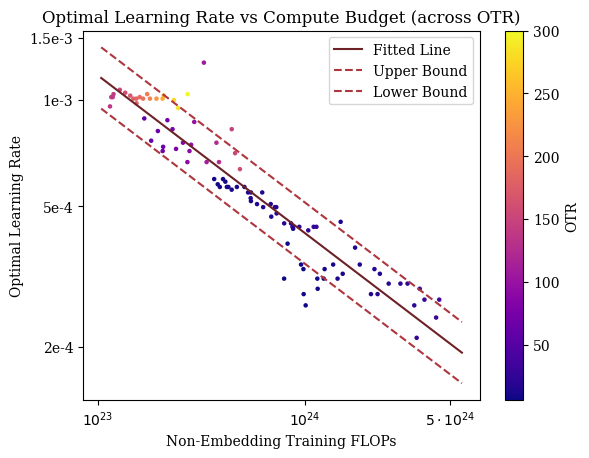

In [18]:
x = np.log(np.array(sampled_points_flop_lr)[:,0])
y = np.log(np.array(sampled_points_flop_lr)[:,1])
c = np.array(sampled_points_ratio_lr)[:,0]


cmap = plt.get_cmap('plasma')
norm = plt.Normalize(min(c), 300)
fig, ax = plt.subplots()

pseudo_x = np.arange(53, 58, 1)
coeffs = np.polyfit(x, y, deg=1)
f = np.poly1d(coeffs)
plt.plot(pseudo_x, f(pseudo_x), color = '#6d2227', label='Fitted Line')
plt.plot(pseudo_x, f(pseudo_x) - 0.2,  linestyle='--', color='#ae363e', label='Upper Bound')
plt.plot(pseudo_x, f(pseudo_x) + 0.2, linestyle='--', color='#ae363e',  label='Lower Bound')

ax = plt.gca() 
ax.set_xlabel('Non-Embedding Training FLOPs', fontsize=10) 
ax.set_ylabel('Optimal Learning Rate', fontsize=10)
ax.tick_params(axis='both', labelsize=10) 

plt.title('Optimal Learning Rate vs Compute Budget (across OTR)')
plt.scatter(x, y, s=5,color = cmap(norm(c)))

plt.yticks([np.log(2 *10 ** (-4)),np.log(5 * 10 ** (-4)), np.log(10 * 10 ** (-4)), np.log(15 * 10 ** (-4))], labels = ['2e-4', '5e-4', '1e-3', '1.5e-3'], fontsize=10)
plt.xticks([np.log(float(1 * 10 ** 23)), np.log(float(1 * 10 ** 24)), np.log(float(5 * 10 ** 24))], labels = ['$10^{23}$', '$10^{24}$', '$5 \cdot 10^{24}$'], fontsize=10)


cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('OTR', fontsize = 10)
cbar.ax.tick_params(labelsize=10) 


plt.legend()
# plt.savefig('optimal_lr_flops_otr.pdf', bbox_inches='tight')

k,b: [-0.36819226 -0.34531054]


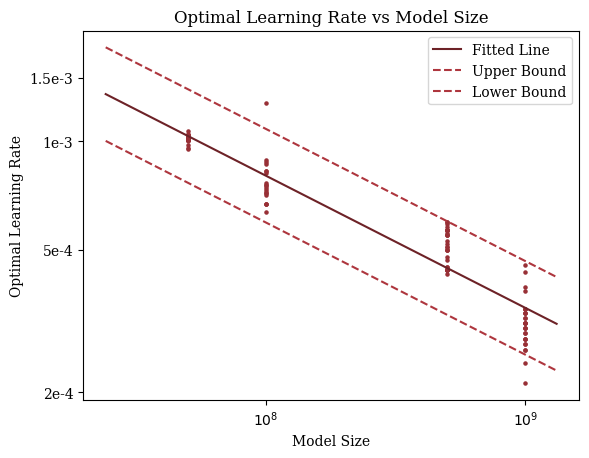

In [19]:
x = np.log(np.array(sampled_points_N_lr)[:,0])
y = np.log(np.array(sampled_points_N_lr)[:,1])

pseudo_x = np.arange(17, 22, 1)
coeffs = np.polyfit(x, y, deg=1)
print('k,b:', coeffs)
f = np.poly1d(coeffs)
plt.plot(pseudo_x, f(pseudo_x), color = '#6d2227', label='Fitted Line')
plt.plot(pseudo_x, f(pseudo_x) - 0.3,  linestyle='--', color='#ae363e', label='Upper Bound')
plt.plot(pseudo_x, f(pseudo_x) + 0.3, linestyle='--', color='#ae363e',  label='Lower Bound')

ax = plt.gca() 
ax.set_xlabel('Model Size', fontsize=10) 
ax.set_ylabel('Optimal Learning Rate', fontsize=10)
ax.tick_params(axis='both', labelsize=10) 
plt.title('Optimal Learning Rate vs Model Size')
plt.scatter(x, y, color='#983036', s=5)

plt.yticks([np.log(2 *10 ** (-4)),np.log(5 * 10 ** (-4)), np.log(10 * 10 ** (-4)), np.log(15 * 10 ** (-4))], labels = ['2e-4', '5e-4', '1e-3', '1.5e-3'], fontsize=10)
plt.xticks([np.log(float(1 * 10 ** 8)), np.log(float(1 * 10 ** 9))], labels = ['$10^8$', '$10^9$'], fontsize=10)



plt.legend()
# plt.savefig('optimal_lr_model_size.pdf', bbox_inches='tight')

k,b: [-0.36819226 -0.34531054]


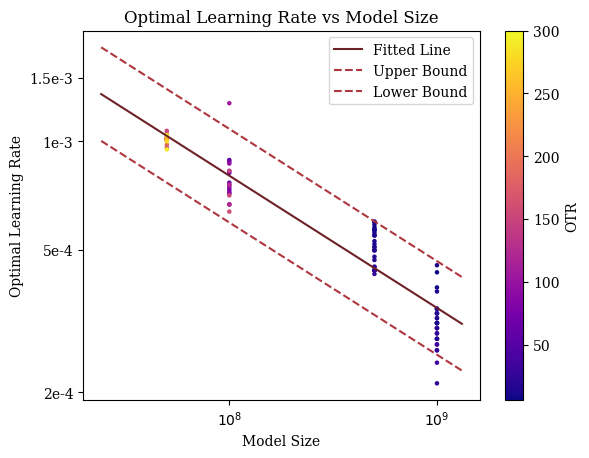

In [20]:
x = np.log(np.array(sampled_points_N_lr)[:,0])
y = np.log(np.array(sampled_points_N_lr)[:,1])
c = np.array(sampled_points_lr_loss)[:,2]

cmap = plt.get_cmap('plasma')
norm = plt.Normalize(min(c), 300)
fig, ax = plt.subplots()
plt.scatter(x, y, s=5, color = cmap(norm(c)))

pseudo_x = np.arange(17, 22, 1)
coeffs = np.polyfit(x, y, deg=1)
print('k,b:', coeffs)
f = np.poly1d(coeffs)
plt.plot(pseudo_x, f(pseudo_x), color = '#6d2227', label='Fitted Line')
plt.plot(pseudo_x, f(pseudo_x) - 0.3,  linestyle='--', color='#ae363e', label='Upper Bound')
plt.plot(pseudo_x, f(pseudo_x) + 0.3, linestyle='--', color='#ae363e',  label='Lower Bound')

# plt.fill_between(np.exp(pseudo_x), np.exp(f(pseudo_x)) - 0.00012, np.exp(f(pseudo_x)) + 0.00012, color='#fbeced', alpha=0.5)

ax = plt.gca() 
ax.set_xlabel('Model Size', fontsize=10) 
ax.set_ylabel('Optimal Learning Rate', fontsize=10)
ax.tick_params(axis='both', labelsize=10) 
plt.title('Optimal Learning Rate vs Model Size')

plt.yticks([np.log(2 *10 ** (-4)),np.log(5 * 10 ** (-4)), np.log(10 * 10 ** (-4)), np.log(15 * 10 ** (-4))], labels = ['2e-4', '5e-4', '1e-3', '1.5e-3'], fontsize=10)
plt.xticks([np.log(float(1 * 10 ** 8)), np.log(float(1 * 10 ** 9))], labels = ['$10^8$', '$10^9$'], fontsize=10)


cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('OTR')
cbar.set_label('OTR', fontsize = 10)
cbar.ax.tick_params(labelsize=10) 

plt.legend()
# plt.savefig('optimal_lr_model_size_otr.pdf', bbox_inches='tight')

[9.04129772 9.04144384 9.04158996 9.04173608 9.04188221 9.04202834
 9.04217447 9.0423206  9.04246673 9.04261287 9.04275901 9.04290515]
k,b: 0.162 2.202


Text(0.5, 1.0, 'Training Loss vs Optimal Learning Rate (across Model Size)')

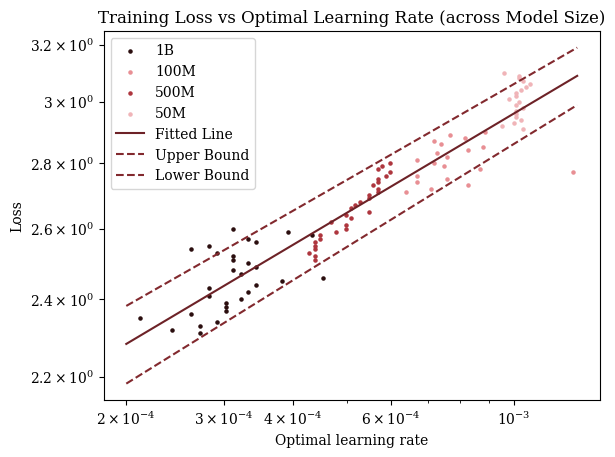

In [21]:
x = np.array(sampled_points_lr_loss)[:,0]
y = np.array(sampled_points_lr_loss)[:,1]


plt.scatter(np.array(sampled_points_lr_loss_1B)[:,0], np.array(sampled_points_lr_loss_1B)[:,1], s=5, color = '#2b0e0f', label = '1B')
plt.scatter(np.array(sampled_points_lr_loss_100M)[:,0], np.array(sampled_points_lr_loss_100M)[:,1], s=5, color = '#e88f94', label = '100M')
plt.scatter(np.array(sampled_points_lr_loss_500M)[:,0], np.array(sampled_points_lr_loss_500M)[:,1], s=5, color = '#ae363e', label = '500M')
plt.scatter(np.array(sampled_points_lr_loss_50M)[:,0], np.array(sampled_points_lr_loss_50M)[:,1], s=5, color = '#f0b4b8', label = '50M')

pseudo_x = np.arange(2, 14, 1) * 10 ** (-4)
coeffs = np.polyfit(np.log(x), np.log(y), deg=1)
f = np.poly1d(coeffs)
plt.plot(pseudo_x, np.exp(f(np.log(pseudo_x))), color = '#6d2227', label='Fitted Line')
plt.plot(pseudo_x, np.exp(f(np.log(pseudo_x))) + 0.1,  linestyle='--', color='#82292e', label='Upper Bound')
plt.plot(pseudo_x, np.exp(f(np.log(pseudo_x))) - 0.1, linestyle='--', color='#82292e',  label='Lower Bound')
print(np.exp(f(pseudo_x)))
print('k,b:', round(coeffs[0],3), round(coeffs[1],3))

# plt.scatter(x, y, s=10)
# plt.fill_between(pseudo_x, f(pseudo_x) + 0.05, f(pseudo_x) - 0.05, color='aliceblue', alpha=0.5)

plt.legend()
plt.xscale('log')
plt.yscale('log')
ax = plt.gca() 

plt.yticks([2.2,2.4, 2.6, 2.8, 3.0, 3.2], fontsize=10)
plt.xticks([2 * 10 ** (-4), 3 * 10 ** (-4), 4 * 10 ** (-4), 6 * 10 ** (-4), 10 * 10 ** (-4)], fontsize=10)

ax.tick_params(axis='both', labelsize=10)
plt.xlabel('Optimal learning rate')
plt.ylabel('Loss')

plt.title('Training Loss vs Optimal Learning Rate (across Model Size)')
# plt.savefig('optimal_lr_loss.pdf', bbox_inches='tight')

k,b: [0.16161023 2.2017704 ]


Text(0.5, 1.0, 'Training Loss vs Optimal Learning Rate (across OTR)')

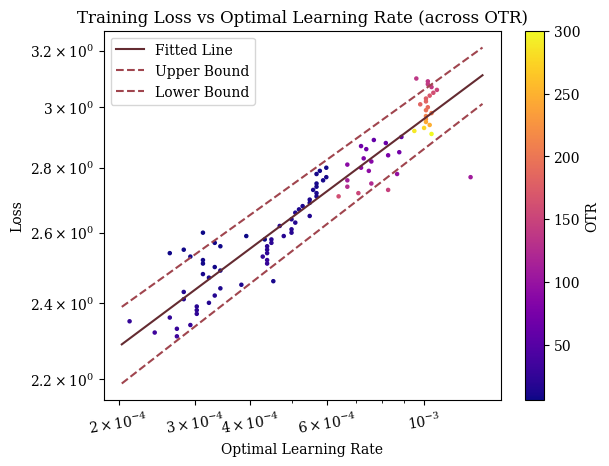

In [22]:
x = np.array(sampled_points_lr_loss)[:,0]
y = np.array(sampled_points_lr_loss)[:,1]
c = np.array(sampled_points_lr_loss)[:,2]

cmap = plt.get_cmap('plasma')
norm = plt.Normalize(min(c), 300)
fig, ax = plt.subplots()
plt.scatter(x, y, s=5, color = cmap(norm(c)))

pseudo_x = np.arange(-8.5, -6.5, 0.1)
coeffs = np.polyfit(np.log(x), np.log(y), deg=1)
print('k,b:', coeffs)
f = np.poly1d(coeffs)
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)), color = '#642b31', label='Fitted Line')
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)) + 0.1,  linestyle='--', color='#a0454e', label='Upper Bound')
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)) - 0.1, linestyle='--', color='#a0454e',  label='Lower Bound')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Optimal Learning Rate')
plt.ylabel('Loss')

ax = plt.gca() 

plt.yticks([2.2, 2.4, 2.6, 2.8, 3.0, 3.2], fontsize=10)
plt.xticks([2 * 10 ** (-4), 3 * 10 ** (-4), 4 * 10 ** (-4), 6 * 10 ** (-4), 10 * 10 ** (-4)], rotation = 9, fontsize=10)

ax.tick_params(axis='both', labelsize=10)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('OTR')
cbar.set_label('OTR', fontsize = 10)
cbar.ax.tick_params(labelsize=10) 
plt.title('Training Loss vs Optimal Learning Rate (across OTR)')
# plt.savefig('optimal_lr_otr_loss.pdf', bbox_inches='tight')